# Velofahren in der Stadt durch die Linse der Zeitreihenanalyse - Zeitreihenanalyse

Detaillierte Informationen zu den Zähldaten von Velofahrten bei der Unterführung Langstrasse an der Ecke Langstrasse - Europaallee (Zürich) sind im Notebook [01-Datenaufbereitung](https://github.com/curdon/velo-prophet/blob/main/Datenanalyse/Code/01-Datenaufbereitung.ipynb) zusammengefasst.

In diesem Notebook werden die aufbereiteten Zähldaten gelesen und mit der Software [Prophet](https://facebook.github.io/prophet/) analysiert. Im Speziellen wird die Zeitreihe in Komponenten wie Trend und Saisonalität aufgeteilt. 

## Python Bibliotheken laden

In [26]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Aufbereitete Velozähldaten laden

In [33]:
velo = pd.read_csv("../Daten/velozaehldaten_aufbereitet.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../Daten/velozaehldaten_aufbereitet.csv'

In [3]:
velo['ds'] = pd.to_datetime(velo['ds'], format="%Y-%m-%dT%H:%M")

## Creating and Fitting Prophet Model

In [4]:
# Creating Prophet model and fitting
velo_model = Prophet(n_changepoints=0)
velo_model.add_country_holidays(country_name='CH')
velo_model.fit(velo)

17:33:30 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing


## Vorhersagen berechnen

In [7]:
velo_vorhersage = velo_model.predict(velo)

## Zeitreihen-Komponenten darstellen

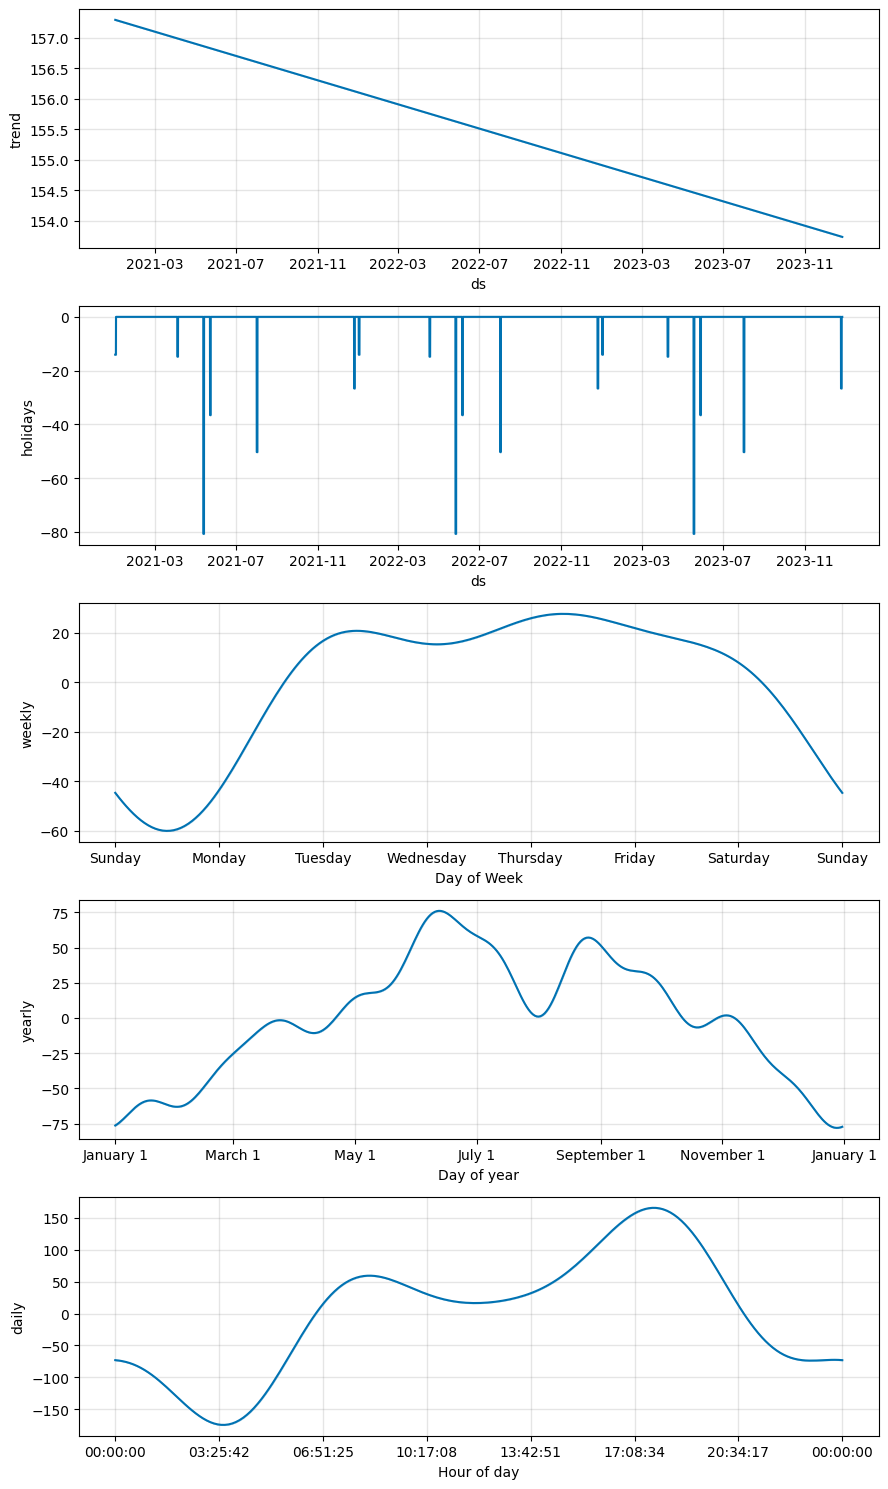

In [22]:
fig_komponenten = velo_model.plot_components(velo_vorhersage)

## Vergleich Vorhersagen und Zählwerte

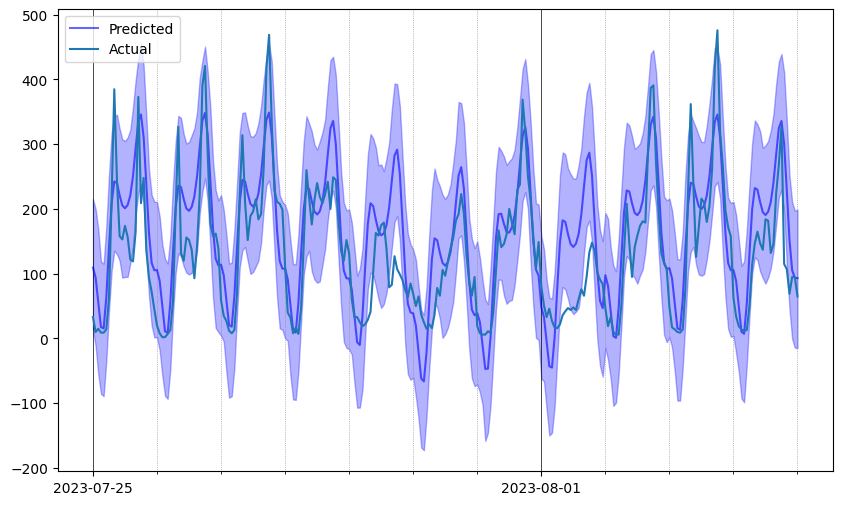

In [18]:
# Filtering data for plotting
start = datetime(2023, 7, 25)
end = datetime(2023, 8, 5)
forecast_filtered = velo_vorhersage[(velo_vorhersage['ds'] >= start) & (velo_vorhersage['ds'] <= end)]
actual_filtered = velo[(velo['ds'] >= start) & (velo['ds'] <= end)]

# Plotting predictions
plt.figure(figsize=(10, 6))
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], color='blue', alpha=0.6, label='Predicted')
plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='blue', alpha=0.3)
plt.plot(actual_filtered['ds'], actual_filtered['y'], label='Actual')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend()

# Setting major and minor gridlines
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Enable grid only for x-axis
ax.xaxis.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')  # Major gridlines for x-axis
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor gridlines for x-axis


plt.show()

## Residuen darstellen

Residuen sind der Unterschied zwischen einem beobachteten Zählwert zu einem Zeitpunkt und dem Vorhersagewert

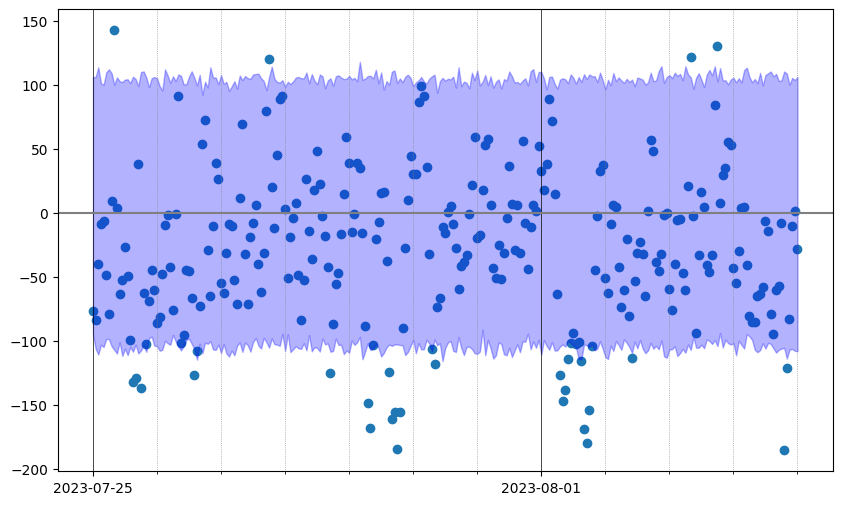

In [20]:
# Calculating residuals
residuals = pd.DataFrame({
    'residuals': actual_filtered['y'] - forecast_filtered['yhat'],
    'ds': actual_filtered['ds'],
    'lower': forecast_filtered['yhat_lower'] - forecast_filtered['yhat'],
    'upper': forecast_filtered['yhat_upper'] - forecast_filtered['yhat']
})

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(residuals['ds'], residuals['residuals'])
plt.fill_between(residuals['ds'], residuals['lower'], residuals['upper'], color='blue', alpha=0.3)
plt.axhline(y=0, color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())

# Setting major and minor gridlines
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Enable grid only for x-axis
ax.xaxis.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')  # Major gridlines for x-axis
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor gridlines for x-axis

plt.show()